<a href="https://colab.research.google.com/github/Jaksta1/Uczenie_Maszynowe_2025/blob/main/Jakub_Kownacki_praca_domowa_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------------------
#1. Importowanie bibliotek
---------------------------------------

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree

-------------------------------------------------
#2. Funkcje pomocnicze
-------------------------------------------------

In [82]:
# -------------------------------
# Funkcja pomocnicza: Obliczenie RSS
# -------------------------------
def compute_rss(y):
    mu = np.mean(y)
    return np.sum((y - mu) ** 2)

# -------------------------------
# Funkcja pomocnicza: Obliczanie kryteriów dla kandydatów na split
# -------------------------------
def candidate_splits(X, y):
    """
    Dla jednowymiarowego uporządkowanego zbioru X i odpowiadających wartości y,
    dla każdego możliwego progu (threshold) oblicza:
      - rss_left: RSS dla lewego podziału (X < threshold)
      - rss_right: RSS dla prawego podziału (X >= threshold)
      - total_rss: suma rss_left + rss_right
      - gain: różnica między RSS rodzica a total_rss
    Zwraca listę z wartościami: threshold, total_rss, gain.
    """
    splits = []
    parent_rss = compute_rss(y)
    # Sortujemy dane względem X
    sort_idx = np.argsort(X[:, 0])
    X_sorted = X[sort_idx, 0]
    y_sorted = y[sort_idx]

    for i in range(1, len(X_sorted)):
        threshold = (X_sorted[i-1] + X_sorted[i]) / 2.0
        left_mask = (X[:, 0] < threshold)
        right_mask = (X[:, 0] >= threshold)
        rss_left = compute_rss(y[left_mask])
        rss_right = compute_rss(y[right_mask])
        total_rss = rss_left + rss_right
        gain = parent_rss - total_rss
        splits.append({
            'threshold': threshold,
            'total_rss': total_rss,
            'gain': gain
        })
    return splits

----------------------------------------------
#3. Generowanie danych
----------------------------------------------

          X         y         Formula
0  0.161292  1.204150  sin(x) + noise
1  0.435915  0.504460  sin(x) + noise
2  0.596779  1.137084  sin(x) + noise
3  0.831950  0.105570  sin(x) + noise
4  0.921049  0.886754  sin(x) + noise


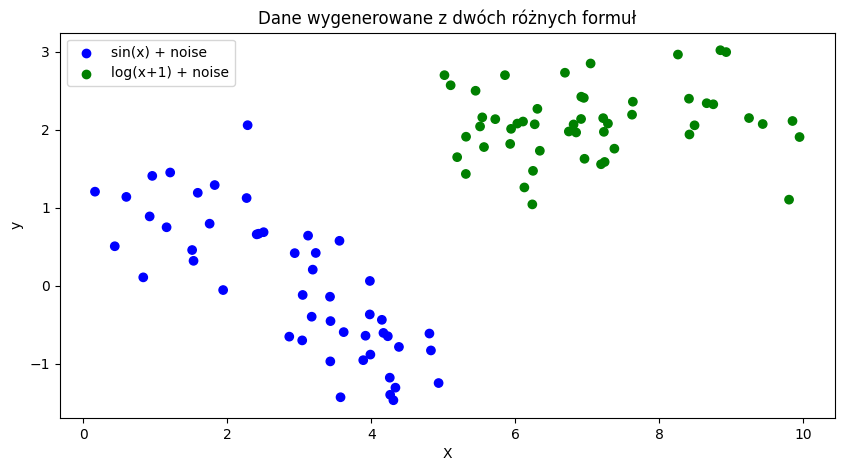

In [83]:
np.random.seed(123)

X = np.sort(np.random.rand(100) * 10).reshape(-1, 1)
X_flat = X.ravel()

# Przygotowanie y z dwóch różnych formuł
y = np.zeros_like(X_flat)
formulas = []

for i, x in enumerate(X_flat):
    noise = np.random.normal(0, 0.5)
    if x < 5:
        y[i] = np.sin(x) + noise
        formulas.append("sin(x) + noise")
    else:
        y[i] = np.log(x + 1) + noise
        formulas.append("log(x+1) + noise")

# Budujemy DataFrame
df = pd.DataFrame({
    'X': X_flat,
    'y': y,
    'Formula': formulas
})

print(df.head())

# Wizualizacja z kolorem zależnym od formuły
colors = df['Formula'].map({'sin(x) + noise': 'blue', 'log(x+1) + noise': 'green'})

plt.figure(figsize=(10,5))
plt.scatter(df['X'], df['y'], c=colors, label=None)
for label, color in zip(['sin(x) + noise', 'log(x+1) + noise'], ['blue', 'green']):
    plt.scatter([], [], c=color, label=label)  # Dla legendy
plt.xlabel('X')
plt.ylabel('y')
plt.title('Dane wygenerowane z dwóch różnych formuł')
plt.legend()
plt.show()

-----------------------------------------------
# 4. Wyznaczenie progów dla drzewa o głębokości 1 za pomocą DecisionTreeRegressor oraz ręcznie za pomocą 3 kryteriów z zadania
-----------------------------------------------

In [84]:
# -------------------------------
# Obliczenie wartości funkcji kryterialnych dla kandydatów na split
# -------------------------------
splits = candidate_splits(X, y)

# Wybieramy najlepszy próg:
# 1. Local RSS Minimization: minimalizacja total_rss
best_local = min(splits, key=lambda s: s['total_rss'])
# 2. RSS Gain Maximization: maksymalizacja gain
best_gain = max(splits, key=lambda s: s['gain'])
# 3. Total RSS Minimization: dla drzewa głębokości 1 jest to to samo, co local RSS Minimization i RSS Gain Maximization, zatem kopiujemy wynik
best_total = best_local.copy()

# -------------------------------
# Trening DecisionTreeRegressor (max_depth=1) i pobranie progu wybranego przez sklearn
# -------------------------------
regressor = DecisionTreeRegressor(max_depth=1)
regressor.fit(X, y)
# Dla drzewa z max_depth=1, pierwszy (i jedyny) podział znajduje się w indeksie 0
sklearn_threshold = regressor.tree_.threshold[0]

----------------------------------------------------------
#5. Prezentacja wyników na wykresach
----------------------------------------------------------

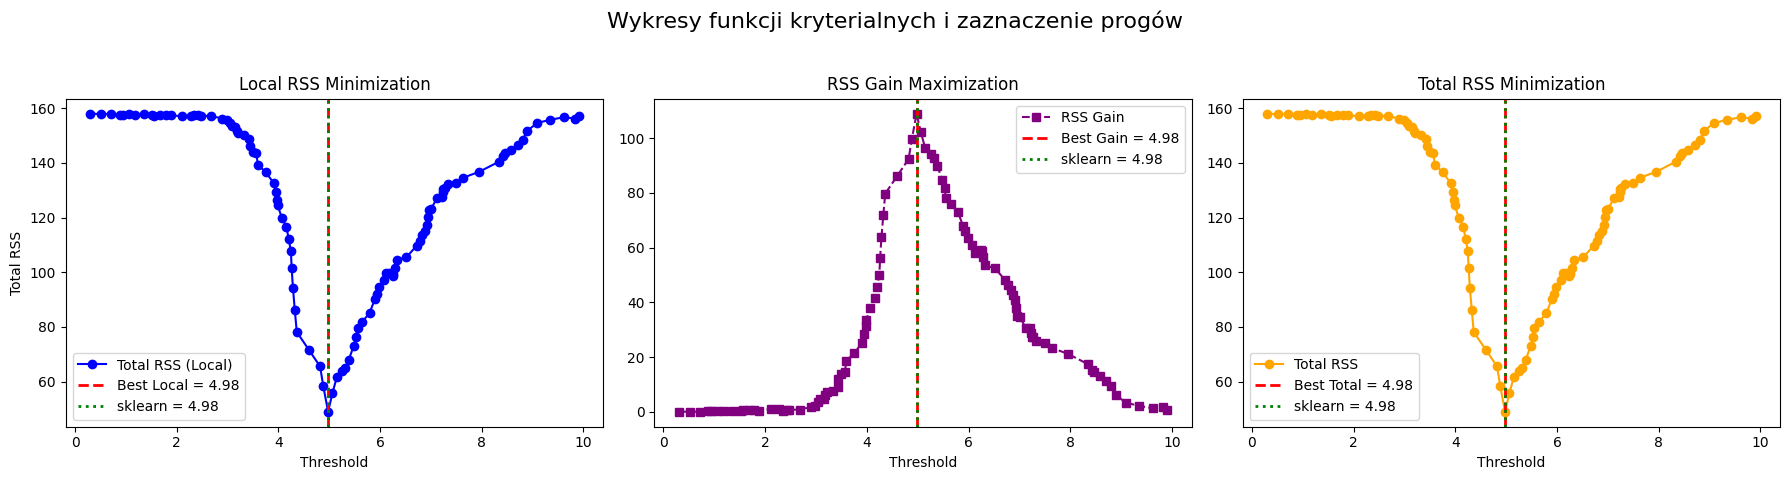

Wyznaczone progi:
1. DecisionTreeRegressor (sklearn): 4.9776
2. Local RSS Minimization:         4.9776
3. RSS Gain Maximization:           4.9776
4. Total RSS Minimization:          4.9776


In [85]:
# Przygotowujemy listy wartości threshold, total_rss i gain
thresholds = [s['threshold'] for s in splits]
rss_values = [s['total_rss'] for s in splits]
gains = [s['gain'] for s in splits]

# Tworzymy trzy wykresy
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# (a) Wykres dla Local RSS Minimization
axs[0].plot(thresholds, rss_values, 'o-', color='blue', label="Total RSS (Local)")
axs[0].axvline(best_local['threshold'], color='red', linestyle='--', linewidth=2,
               label=f"Best Local = {best_local['threshold']:.2f}")
axs[0].axvline(sklearn_threshold, color='green', linestyle=':', linewidth=2,
               label=f"sklearn = {sklearn_threshold:.2f}")
axs[0].set_xlabel("Threshold")
axs[0].set_ylabel("Total RSS")
axs[0].set_title("Local RSS Minimization")
axs[0].legend()

# (b) Wykres dla RSS Gain Maximization
axs[1].plot(thresholds, gains, 's--', color='purple', label="RSS Gain")
axs[1].axvline(best_gain['threshold'], color='red', linestyle='--', linewidth=2,
               label=f"Best Gain = {best_gain['threshold']:.2f}")
axs[1].axvline(sklearn_threshold, color='green', linestyle=':', linewidth=2,
               label=f"sklearn = {sklearn_threshold:.2f}")
axs[1].set_xlabel("Threshold")
axs[1].set_title("RSS Gain Maximization")
axs[1].legend()

# (c) Wykres dla Total RSS Minimization (dla pojedynczego podziału, taki sam jak local)
axs[2].plot(thresholds, rss_values, 'o-', color='orange', label="Total RSS")
axs[2].axvline(best_total['threshold'], color='red', linestyle='--', linewidth=2,
               label=f"Best Total = {best_total['threshold']:.2f}")
axs[2].axvline(sklearn_threshold, color='green', linestyle=':', linewidth=2,
               label=f"sklearn = {sklearn_threshold:.2f}")
axs[2].set_xlabel("Threshold")
axs[2].set_title("Total RSS Minimization")
axs[2].legend()

fig.suptitle("Wykresy funkcji kryterialnych i zaznaczenie progów", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# -------------------------------
# Wypisanie wszystkich czterech progów
# -------------------------------
print("Wyznaczone progi:")
print(f"1. DecisionTreeRegressor (sklearn): {sklearn_threshold:.4f}")
print(f"2. Local RSS Minimization:         {best_local['threshold']:.4f}")
print(f"3. RSS Gain Maximization:           {best_gain['threshold']:.4f}")
print(f"4. Total RSS Minimization:          {best_total['threshold']:.4f}")


------------------------------------------------
#6. Wyznaczenie optymalnych progów dla drzewa o głębokości 2
------------------------------------------------

In [86]:
# ---------------------------
# Metoda 1: Lokalna minimalizacja RSS (dla węzła korzenia)
# ---------------------------
candidate_thresholds = []
rss_values = []

for i in range(1, len(X)):
    thresh = (X[i - 1, 0] + X[i, 0]) / 2
    left_mask = X[:, 0] < thresh
    right_mask = ~left_mask
    ssr_left = compute_rss(y[left_mask])
    ssr_right = compute_rss(y[right_mask])
    total_rss = ssr_left + ssr_right
    candidate_thresholds.append(thresh)
    rss_values.append(total_rss)

idx_best_m1 = np.argmin(rss_values)
best_thresh_m1 = candidate_thresholds[idx_best_m1]

# ---------------------------
# Metoda 2: Maksymalizacja zysku RSS
# ---------------------------
parent_rss = compute_rss(y)
gains = [parent_rss - rss for rss in rss_values]
idx_best_m2 = np.argmax(gains)
best_thresh_m2 = candidate_thresholds[idx_best_m2]

# ---------------------------
# Metoda 3: Minimalizacja łącznego RSS dla drzewa o głębokości 2
# ---------------------------
total_rss_depth2 = []

for thresh in candidate_thresholds:
    left_mask = X[:, 0] < thresh
    right_mask = ~left_mask
    y_left = y[left_mask]
    y_right = y[right_mask]

    # Szukanie optymalnego podziału w lewym zbiorze
    if len(y_left) >= 2:
        candidate_thresholds_left = []
        rss_left_values = []
        X_left = X[left_mask]
        for j in range(1, len(X_left)):
            t_left = (X_left[j - 1, 0] + X_left[j, 0]) / 2
            left_left_mask = X_left[:, 0] < t_left
            left_right_mask = ~left_left_mask
            ssr_left_left = compute_rss(y_left[left_left_mask])
            ssr_left_right = compute_rss(y_left[left_right_mask])
            candidate_thresholds_left.append(t_left)
            rss_left_values.append(ssr_left_left + ssr_left_right)
        best_left_rss = min(rss_left_values)
    else:
        best_left_rss = compute_rss(y_left)

    # Szukanie optymalnego podziału w prawym zbiorze
    if len(y_right) >= 2:
        candidate_thresholds_right = []
        rss_right_values = []
        X_right = X[right_mask]
        for j in range(1, len(X_right)):
            t_right = (X_right[j - 1, 0] + X_right[j, 0]) / 2
            right_left_mask = X_right[:, 0] < t_right
            right_right_mask = ~right_left_mask
            ssr_right_left = compute_rss(y_right[right_left_mask])
            ssr_right_right = compute_rss(y_right[right_right_mask])
            candidate_thresholds_right.append(t_right)
            rss_right_values.append(ssr_right_left + ssr_right_right)
        best_right_rss = min(rss_right_values)
    else:
        best_right_rss = compute_rss(y_right)

    total_rss_depth2.append(best_left_rss + best_right_rss)

idx_best_m3 = np.argmin(total_rss_depth2)
best_thresh_m3 = candidate_thresholds[idx_best_m3]

# ---------------------------
# Metoda 4: DecisionTreeRegressor z scikit-learn (max_depth=2)
# ---------------------------
tree = DecisionTreeRegressor(max_depth=2)
tree.fit(X, y)
best_thresh_sk = tree.tree_.threshold[0]

------------------------------------------------------------------
#7. Wygenerowanie wykresów
------------------------------------------------------------------

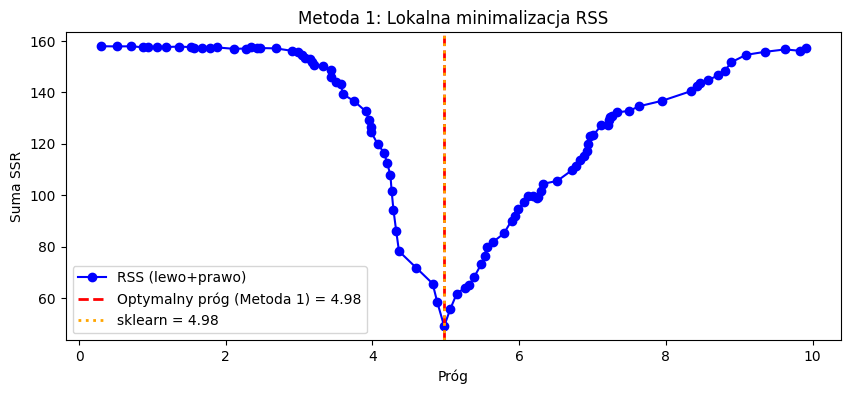

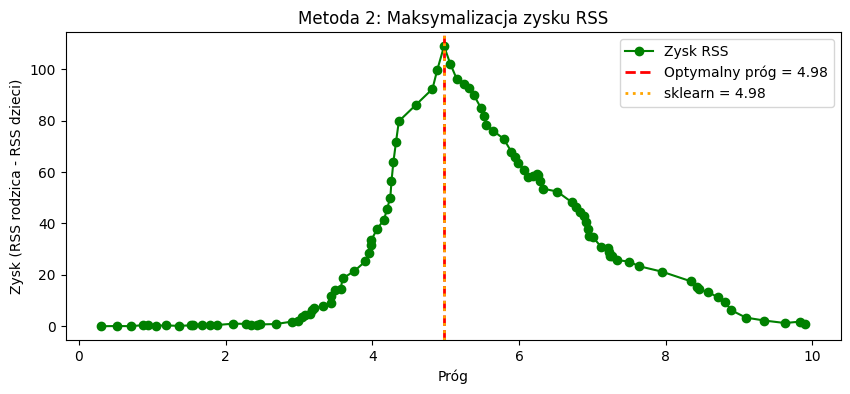

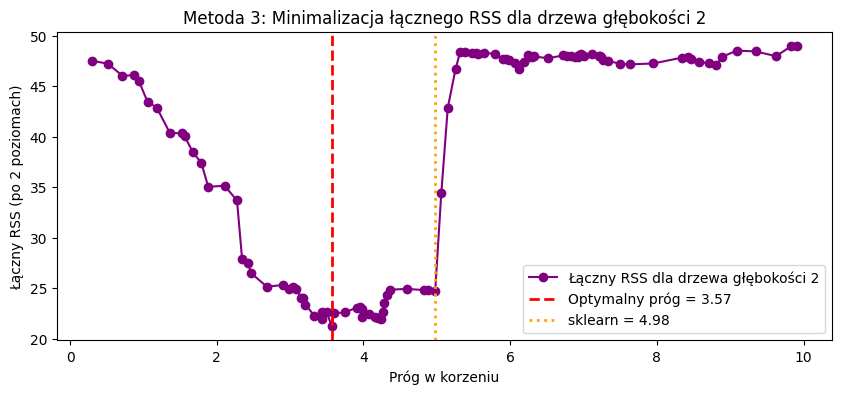

Podsumowanie optymalnych progów:
Metoda 1 (Lokalne minimalizowanie RSS): 4.9776
Metoda 2 (Maksymalizacja zysku RSS): 4.9776
Metoda 3 (Minimalizacja łącznego RSS dla drzewa głębokości 2): 3.5666
DecisionTreeRegressor (max_depth=2): 4.9776


In [87]:
# Wykres dla Metody 1
plt.figure(figsize=(10,4))
plt.plot(candidate_thresholds, rss_values, '-o', color='blue', label="RSS (lewo+prawo)")
plt.axvline(x=best_thresh_m1, color='red', linestyle='--', linewidth=2,
            label=f'Optymalny próg (Metoda 1) = {best_thresh_m1:.2f}')
plt.axvline(x=best_thresh_sk, color='orange', linestyle=':', linewidth=2,
            label=f'sklearn = {best_thresh_sk:.2f}')
plt.xlabel("Próg")
plt.ylabel("Suma SSR")
plt.title("Metoda 1: Lokalna minimalizacja RSS")
plt.legend()
plt.show()


# Wykres dla Metody 2
plt.figure(figsize=(10,4))
plt.plot(candidate_thresholds, gains, '-o', color='green', label="Zysk RSS")
plt.axvline(x=best_thresh_m2, color='red', linestyle='--', linewidth=2,
            label=f'Optymalny próg = {best_thresh_m2:.2f}')
plt.axvline(x=best_thresh_sk, color='orange', linestyle=':', linewidth=2,
            label=f'sklearn = {best_thresh_sk:.2f}')
plt.xlabel("Próg")
plt.ylabel("Zysk (RSS rodzica - RSS dzieci)")
plt.title("Metoda 2: Maksymalizacja zysku RSS")
plt.legend()
plt.show()


# Wykres dla Metody 3
plt.figure(figsize=(10,4))
plt.plot(candidate_thresholds, total_rss_depth2, '-o', color='purple', label="Łączny RSS dla drzewa głębokości 2")
plt.axvline(x=best_thresh_m3, color='red', linestyle='--', linewidth=2,
            label=f'Optymalny próg = {best_thresh_m3:.2f}')
plt.axvline(x=best_thresh_sk, color='orange', linestyle=':', linewidth=2,
            label=f'sklearn = {best_thresh_sk:.2f}')
plt.xlabel("Próg w korzeniu")
plt.ylabel("Łączny RSS (po 2 poziomach)")
plt.title("Metoda 3: Minimalizacja łącznego RSS dla drzewa głębokości 2")
plt.legend()
plt.show()


# ---------------------------
# Podsumowanie wyników
# ---------------------------
print("Podsumowanie optymalnych progów:")
print("Metoda 1 (Lokalne minimalizowanie RSS): {:.4f}".format(best_thresh_m1))
print("Metoda 2 (Maksymalizacja zysku RSS): {:.4f}".format(best_thresh_m2))
print("Metoda 3 (Minimalizacja łącznego RSS dla drzewa głębokości 2): {:.4f}".format(best_thresh_m3))
print("DecisionTreeRegressor (max_depth=2): {:.4f}".format(best_thresh_sk))

---------------------------------------------
#8. Odpowiedzi na pytania
---------------------------------------------

Kryteria podziału

1. **Lokalna minimalizacja RSS**

   Wybieramy cechę $X_j$ i próg $t$, które minimalizują sumę kwadratów błędów (RSS) w dwóch powstałych węzłach potomnych:  
   $$
   [X_j^*, t^*] = \arg \min_{X_j, t} \sum_{m=1}^2 \sum_{i: x_i \in R_m[X_j, t]} (y_i - \bar{y}_{R_m})^2
   $$

2. **Maksymalizacja zysku RSS**  
   Wybieramy cechę $X_j$ i próg $t$, które maksymalizują redukcję RSS, obliczaną jako różnica między RSS węzła rodzica a sumą RSS węzłów potomnych:  
   $$
   [X_j^*, t^*] = \arg \max_{X_j, t} \left( \sum_{i: x_i \in \text{Parent}} (y_i - \bar{y})^2 - \sum_{m=1}^2 \sum_{i: x_i \in R_m[X_j, t]} (y_i - \bar{y}_{R_m})^2 \right)
   $$

3. **Minimalizacja całkowitego RSS**  
   Dla drzewa $T$ i podziału na cechę $X_j$ przy progu $t$, definiujemy nowe drzewo $T[X_j, t]$ z liśćmi $R_1[X_j, t]$ i $R_2[X_j, t]$. Cel to minimalizacja całkowitej sumy kwadratów reszt:  
   $$
   [X_j^*, t^*] = \arg \min_{X_j, t} \sum_{m \in \text{Leaves}[T[X_j, t]]} \sum_{i \in R_m} (y_i - \bar{y}_{R_m})^2
   $$

##1. Czy lokalna minimalizacja RSS i maksymalizacja zysku RSS są równoważne?
Lokalna minimalizacja RSS minimalizuje sumę RSS w węzłach potomnych: $\text{RSS}_{\text{left}} + \text{RSS}_{\text{right}}$, podczas gdy maksymalizacja zysku RSS maksymalizuje $\text{RSS}_{\text{parent}} - (\text{RSS}_{\text{left}} + \text{RSS}_{\text{right}})$.


Ponieważ $\text{RSS}_{\text{parent}}$ jest stałe dla danego węzła, minimalizacja $\text{RSS}_{\text{left}} + \text{RSS}_{\text{right}}$ jest równoważna maksymalizacji $\text{RSS}_{\text{parent}} - (\text{RSS}_{\text{left}} + \text{RSS}_{\text{right}})$. Wynika z tego, że te dwa kryteria są równoważne.

Jest to zgodne z wyliczonymi progami dla obydwu naszych drzew o głębokości 1 i 2, dla których wyniki zostały przedstawione w punktach 5 i 7. W obu przypadkach progi wyliczone za pomocą obu tych metod pokrywają się.

##2. Czy minimalizacja całkowitego RSS pokrywa się z którymś z tych dwóch, czy jest odrębna?
W przypadku drzewa o głębokości 1 (jeden podział), całkowite RSS jest równe sumie RSS węzłów potomnych, co pokrywa się z lokalną minimalizacją RSS. Natomiast dla głębszych drzew całkowite RSS uwzględnia wszystkie liście, więc może się różnić od lokalnego podejścia.

Widać to na przykładzie wyników z punktów 5 i 7. Dla drzewa głębokości 1 bierzemy tę samą wartość, bo drzewo zawiera tylko dwa liście (węzły potomne).
Natomiast biorąc drzewo o głębokości 2 otrzymujemy, że metoda minimalizacji całkowitego RSS daje zupełnie inny wynik niż dwie pozostałe metody, które zgodnie z odpowiedzią na pierwsze pytanie zwracają tę samą wartość.

##3. Która z przedstawionych metod pokrywa się z wynikami uzyskanymi przez DecisionTreeRegressor z pakietu scikit-learn?

Jak widać w przypadku obu drzew DecisionTreeRegressor zwrócił ten sam próg co lokalna minimalizacja RSS i maksymalizacja zysku RSS, zatem najpewniej jedna z tych metod została zaimplementowana w pakiecie scikit-learn.